In [1]:
# import libraries 
import pandas as pd # Import Pandas for data manipulation using dataframes
import numpy as np # Import Numpy for data statistical analysis 
import matplotlib.pyplot as plt # Import matplotlib for data visualisation
import seaborn as sns
import random

%matplotlib inline
sns.set_style("whitegrid")

In [2]:
label_mapping = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

class_names = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [3]:
fashion_train_df = pd.read_csv('./fashion-mnist_train.csv')
fashion_test_df = pd.read_csv('./fashion-mnist_test.csv')

print("Training Data Preview:")
print(fashion_train_df.head())  # Display in grid format

print("\nTesting Data Preview:")
print(fashion_test_df.head())

Training Data Preview:
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0      

In [4]:
# Check for missing values in the training and testing datasets
print("\nChecking for missing values in training data:")
print(fashion_train_df.isnull().sum())

print("\nChecking for missing values in testing data:")
print(fashion_test_df.isnull().sum())

# If there are missing values, handle them (example: fill with mean or drop rows)
if fashion_train_df.isnull().values.any():
    print("\nHandling missing values in training data...")
    fashion_train_df.fillna(fashion_train_df.mean(), inplace=True)  # Filling missing values with column mean

if fashion_test_df.isnull().values.any():
    print("\nHandling missing values in testing data...")
    fashion_test_df.fillna(fashion_test_df.mean(), inplace=True)  # Filling missing values with column mean


Checking for missing values in training data:
label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

Checking for missing values in testing data:
label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64


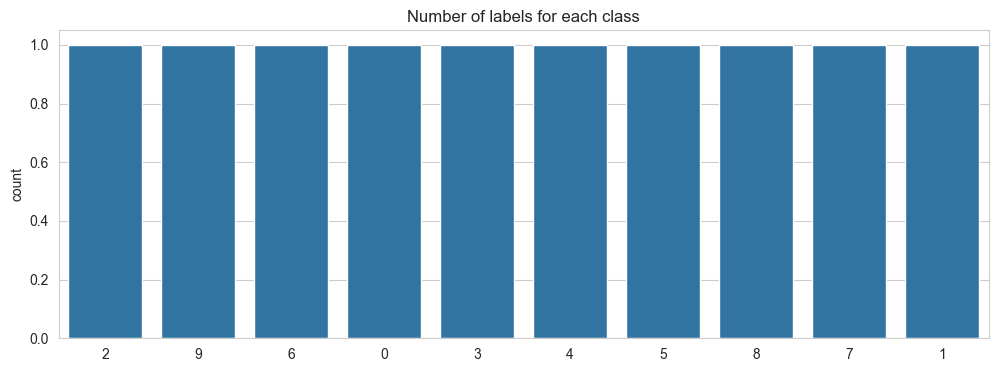

In [5]:
def plot_label_per_class(data):
    f, ax = plt.subplots(1,1, figsize=(12,4))
    g = sns.countplot(data.label, order = data["label"].value_counts().index)
    g.set_title("Number of labels for each class")

    for p, label in zip(g.patches, data["label"].value_counts().index):
        g.annotate(class_names[label], (p.get_x(), p.get_height()+0.1))
    plt.show()  
    
plot_label_per_class(fashion_train_df)

In [6]:
train = np.array(fashion_train_df, dtype='float32')
test = np.array(fashion_test_df, dtype='float32')

In [7]:
train.shape

(60000, 785)

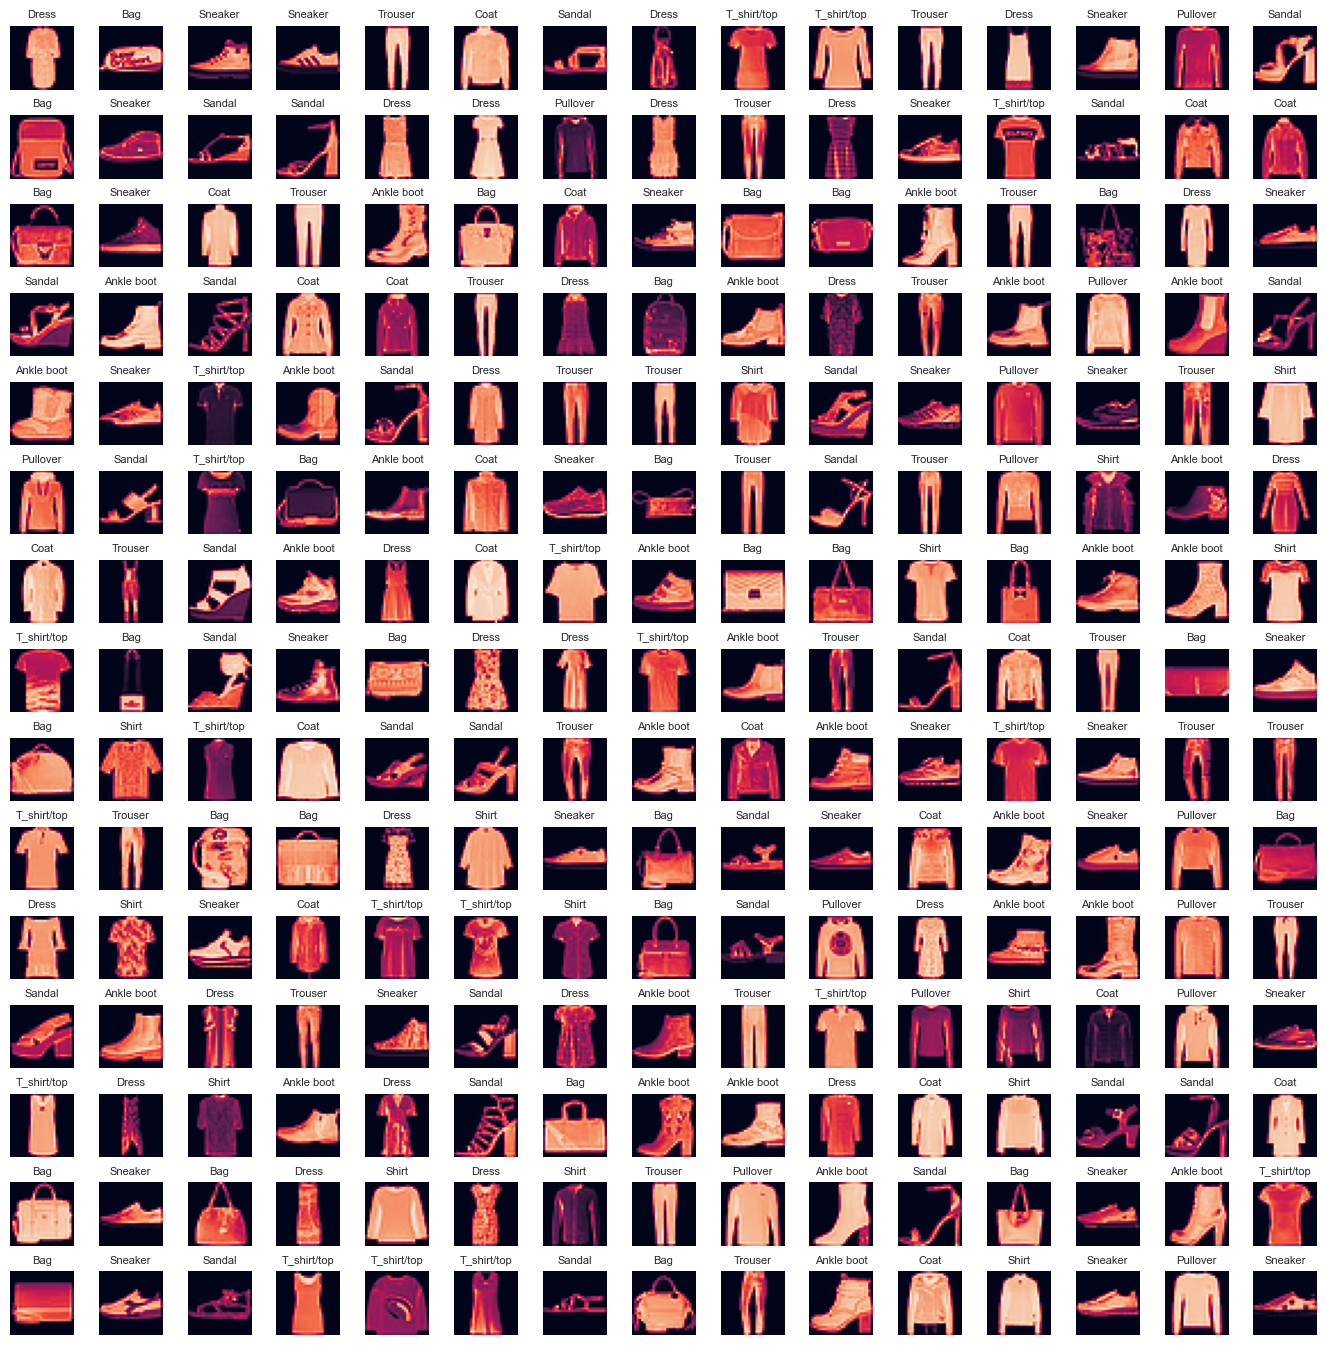

In [8]:
# Define the dimensions of the plot grid 
W_grid = 15
L_grid = 15

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize=(17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_train = len(train) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index    
    axes[i].imshow( train[index,1:].reshape((28,28)) )
    label_index = int(train[index,0])
    axes[i].set_title(class_names[label_index], fontsize=8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

In [9]:
# Prepare the training and testing dataset 
X_train = train[:, 1:] / 255
y_train = train[:, 0]

X_test = test[:, 1:] / 255
y_test = test[:,0]

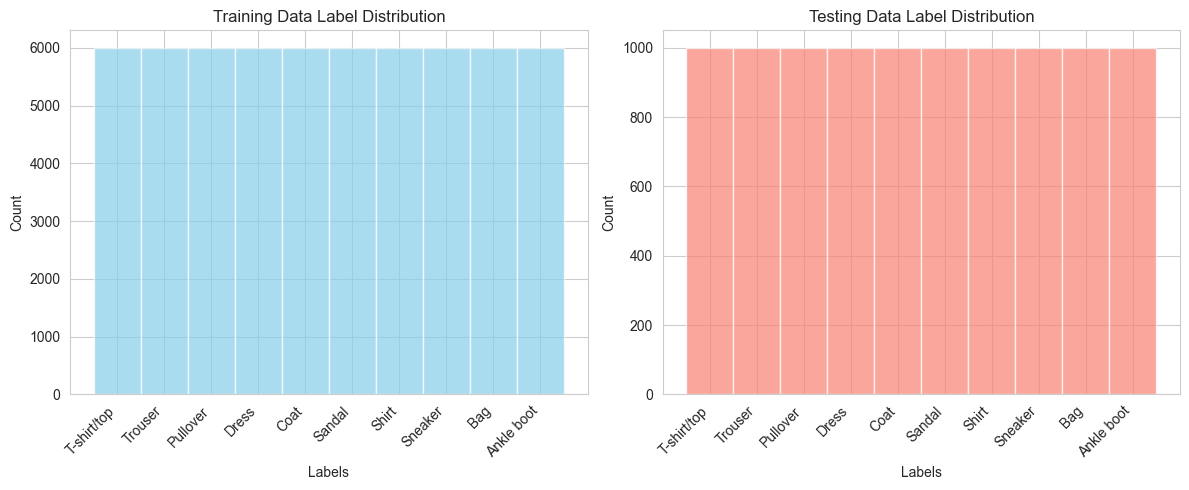

In [59]:
label_mapping = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

# Replace numeric labels with string labels using list comprehension
y_train_full_mapped = np.array([label_mapping[int(label)] for label in y_train])
y_test_mapped = np.array([label_mapping[int(label)] for label in y_test])

# Visualize the label distribution in the training and testing datasets
plt.figure(figsize=(12, 5))

# Training data label distribution
plt.subplot(1, 2, 1)
plt.hist(y_train_full_mapped, bins=np.arange(len(label_mapping) + 1) - 0.5, color='skyblue', alpha=0.7)
plt.title("Training Data Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(np.arange(len(label_mapping)), list(label_mapping.values()), rotation=45, ha='right')

# Testing data label distribution
plt.subplot(1, 2, 2)
plt.hist(y_test_mapped, bins=np.arange(len(label_mapping) + 1) - 0.5, color='salmon', alpha=0.7)
plt.title("Testing Data Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(np.arange(len(label_mapping)), list(label_mapping.values()), rotation=45, ha='right')

plt.tight_layout()
plt.show()

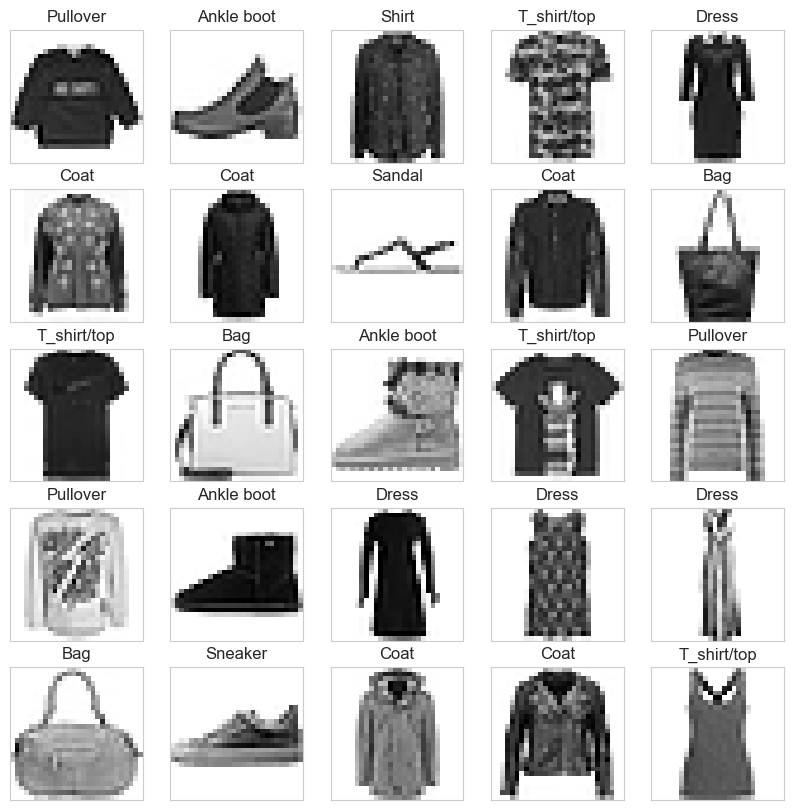

<Figure size 640x480 with 0 Axes>

In [10]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape((28,28)), cmap=plt.cm.binary)
    label_index = int(y_train[i])
    plt.title(class_names[label_index])
plt.show()
plt.tight_layout()

Text(0.5, 1.0, 'Class distribution in testing set')

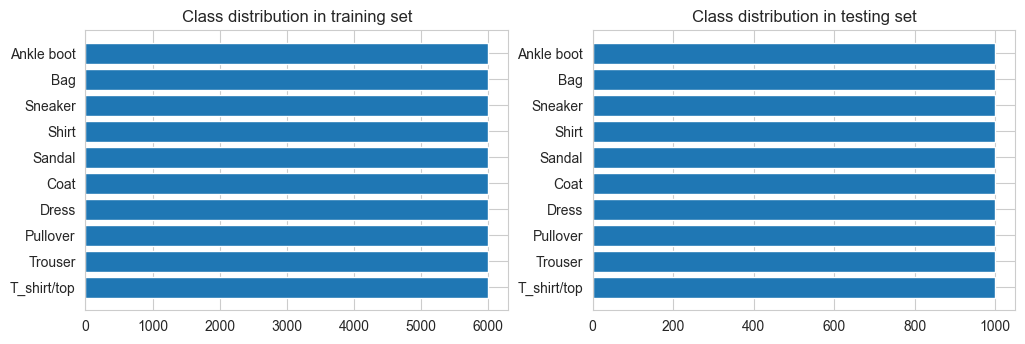

In [11]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
classes, counts = np.unique(y_train, return_counts=True)
plt.barh(class_names, counts)
plt.title('Class distribution in training set')

plt.subplot(2, 2, 2)
classes, counts = np.unique(y_test, return_counts=True)
plt.barh(class_names, counts)
plt.title('Class distribution in testing set')

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [13]:
# * unpack the tuple
X_train = X_train.reshape(X_train.shape[0], * (28, 28, 1))
X_test = X_test.reshape(X_test.shape[0], * (28, 28, 1))
X_validate = X_validate.reshape(X_validate.shape[0], * (28, 28, 1))

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
import keras
import tensorflow as tf

In [17]:
cnn_model = Sequential()

# Try 32 fliters first then 64
cnn_model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(28,28,1), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(28,28,1), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(28,28,1), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(28,28,1), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.2))

# cnn_model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(28,28,1), activation='relu'))
# cnn_model.add(BatchNormalization())
# cnn_model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(28,28,1), activation='relu'))
# cnn_model.add(BatchNormalization())
# cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
# cnn_model.add(Dropout(0.25))

# cnn_model.add(Conv2D(32,3, 3, activation='relu'))
# cnn_model.add(MaxPooling2D(pool_size = (2, 2)))

cnn_model.add(Flatten())
cnn_model.add(Dense(units=128, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(units=10, activation='softmax'))

In [18]:
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer='adam' ,metrics=['accuracy'])

In [22]:
cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,404,992 (5.36 MB)

 Trainable params: 468,202 (1.79 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 936,406 (3.57 MB)

In [19]:
epochs = 50
batch_size = 512

history = cnn_model.fit(
    X_train, y_train, 
    batch_size=batch_size, 
    epochs=epochs,
    verbose=1, 
    validation_data=(X_validate, y_validate)
)

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 34s 347ms/step - accuracy: 0.6713 - loss: 1.1690 - val_accuracy: 0.1120 - val_loss: 3.0797
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 34s 359ms/step - accuracy: 0.8663 - loss: 0.3714 - val_accuracy: 0.2023 - val_loss: 2.9004
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 32s 341ms/step - accuracy: 0.8883 - loss: 0.3029 - val_accuracy: 0.2962 - val_loss: 3.1384
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 30s 319ms/step - accuracy: 0.9035 - loss: 0.2640 - val_accuracy: 0.3781 - val_loss: 3.4458
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 30s 323ms/step - accuracy: 0.9141 - loss: 0.2343 - val_accuracy: 0.4457 - val_loss: 3.1061
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 30s 319ms/step - accuracy: 0.9180 - loss: 0.2211 - val_accuracy: 0.6885 - val_loss: 1.1478
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 32s 342ms/step - accuracy: 0.9244 - loss: 0.2035 - val_accuracy: 0.8162 - val_loss: 0.5853
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 83s 892ms/step - accuracy: 0.9290 - loss: 0.1924 - val_accu

In [23]:
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9334 - loss: 0.2721
Test Loss: 0.2730455994606018
Test Accuracy: 0.9359999895095825


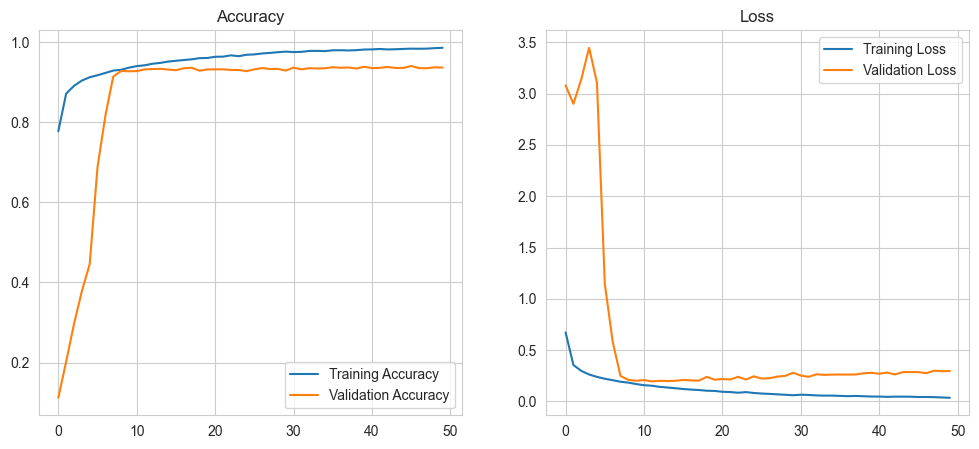

In [24]:
# Visualize accuracy and loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()

In [28]:
# get the predictions for the test data
predicted_classes = cnn_model.predict(X_test)
predicted_classes = np.argmax(predicted_classes, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [29]:
test_img = X_test[0]
prediction = cnn_model.predict(X_test)
prediction[0]

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


array([1.0000000e+00, 3.0963000e-21, 3.0196464e-13, 2.1846706e-12,
       1.0161885e-17, 1.4759256e-24, 5.1015719e-12, 1.8739227e-20,
       7.7337036e-18, 7.0282086e-23], dtype=float32)

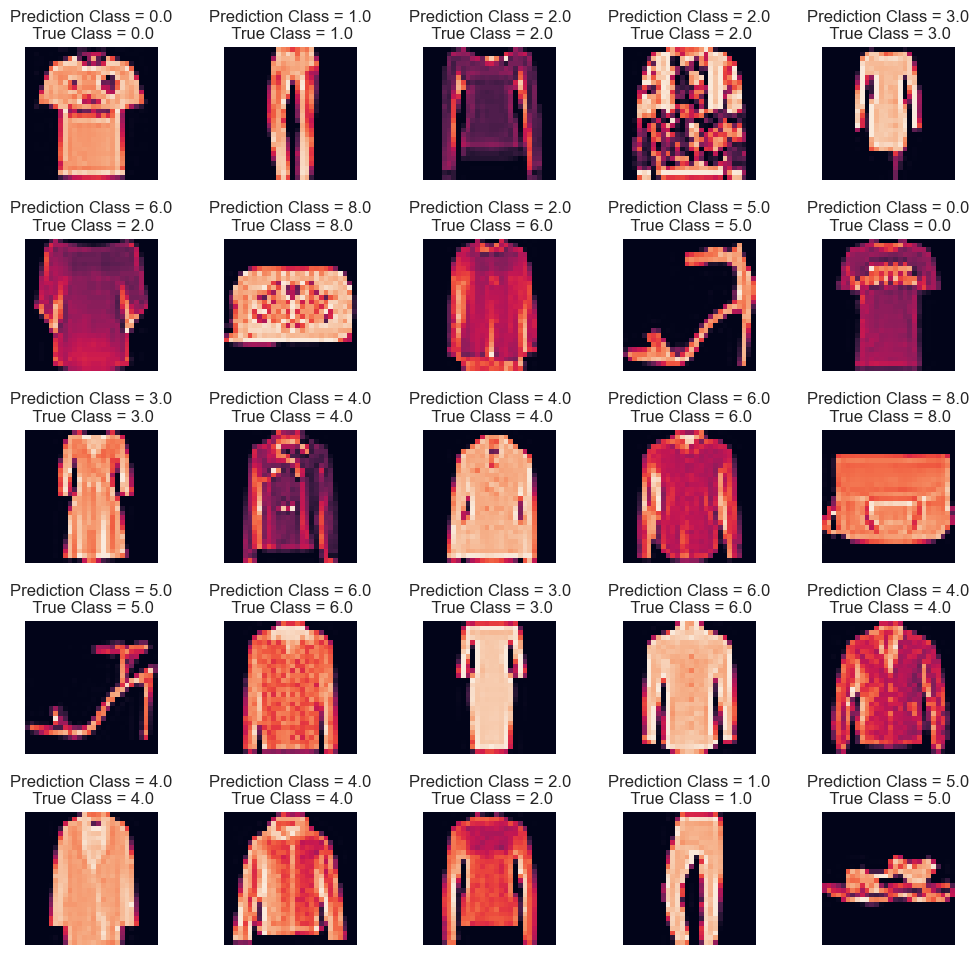

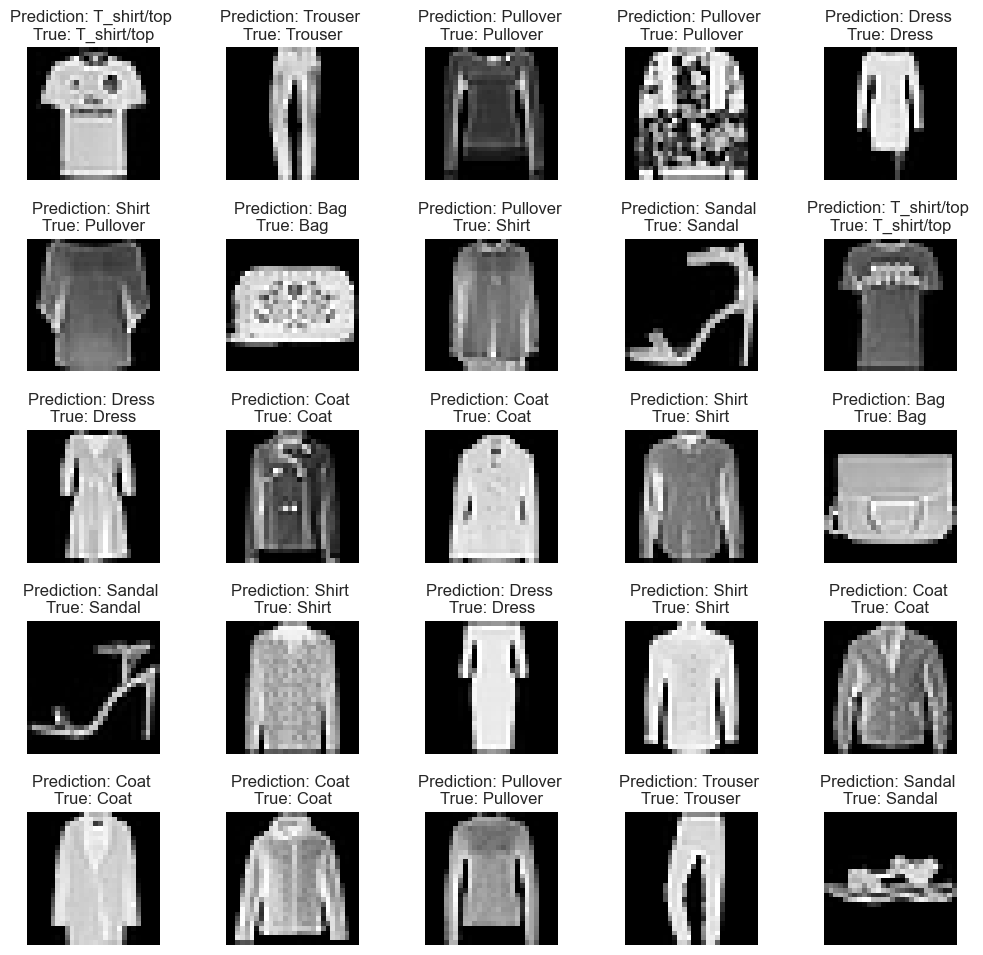

In [49]:
L = 5
W = 5
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L * W):  
    axes[i].imshow(X_test[i].reshape(28,28))
    axes[i].set_title(f"Prediction Class = {(predicted_classes[i]):0.1f}\n True Class = {y_test[i]:0.1f}")
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)

L = 5
W = 5
fig, axes = plt.subplots(L, W, figsize=(12,12))
axes = axes.ravel()

# Assuming class_names is a list of class labels
# For example: class_names = ['Class 0', 'Class 1', ..., 'Class N']

for i in np.arange(0, L * W):  
    axes[i].imshow(X_test[i].reshape(28, 28), cmap='gray')
    axes[i].set_title(f"Prediction: {class_names[int(predicted_classes[i])]} \nTrue: {class_names[int(y_test[i])]}")  # Use class_names
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)


<Axes: >

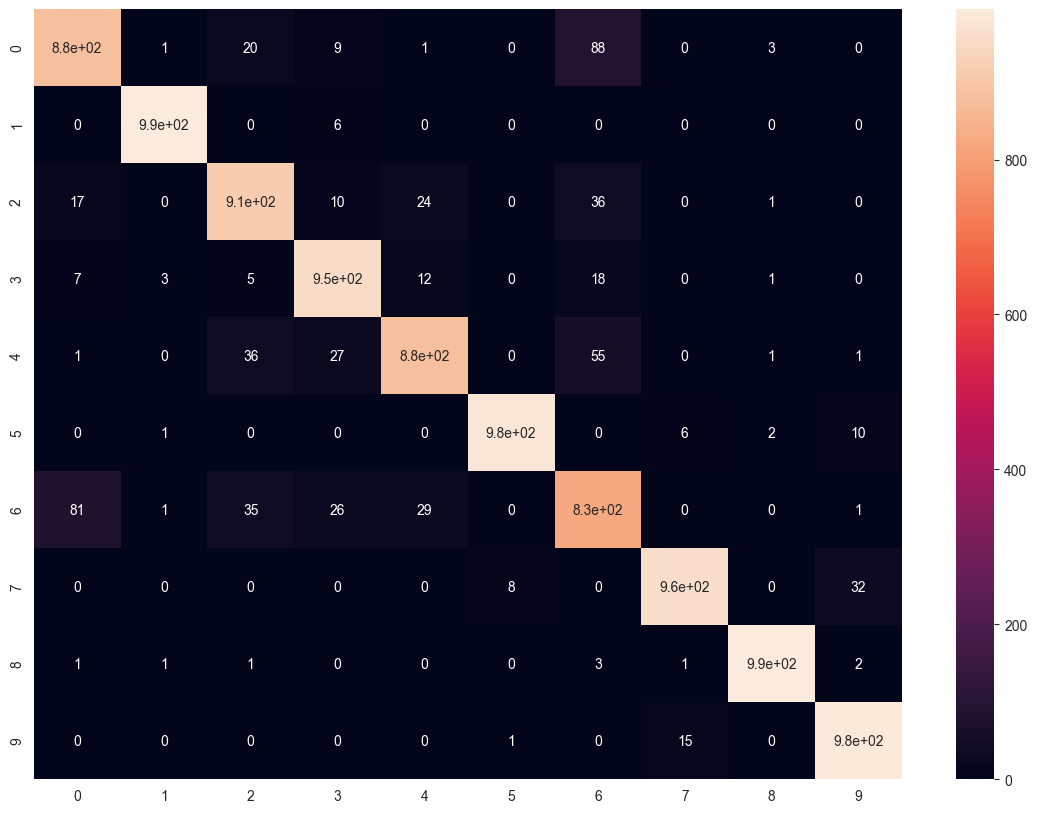

In [48]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize = (14,10))
sns.heatmap(cm, annot=True)

In [33]:
from sklearn.metrics import classification_report

num_classes = 10
target_names = [f"Class {i}" for i in range(num_classes)]

print(classification_report(y_test, predicted_classes, target_names = target_names))

              precision    recall  f1-score   support

     Class 0       0.89      0.88      0.88      1000
     Class 1       0.99      0.99      0.99      1000
     Class 2       0.90      0.91      0.91      1000
     Class 3       0.92      0.95      0.94      1000
     Class 4       0.93      0.88      0.90      1000
     Class 5       0.99      0.98      0.99      1000
     Class 6       0.81      0.83      0.82      1000
     Class 7       0.98      0.96      0.97      1000
     Class 8       0.99      0.99      0.99      1000
     Class 9       0.96      0.98      0.97      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

